# Deep Dream
Here, we use TensorFlow to automatically derive the gradient for a given layer in the network with respect to the input image. The gradient is then used to update the input image. This procedure is repeated a number of times for interesting patterns

In [21]:
%matplotlib inline
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
#Loading  pre trained network inception

model_fn = '/home/vijay/workspace/ml/databases/models/inception3/classify_image_graph_def.pb'
image_path = '/home/vijay/workspace/ml/databases/models/inception3/cropped_panda.jpg'
#Create a Tensorflow session ans loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(graph_def)

In [3]:
# Lets get the list of all operations in the graph

layers = [op.name for op in graph.get_operations()]
print('\nNumber of layers:', len(layers))
layers[0:20] # first few operations in the graph


Number of layers: 1004


['import/DecodeJpeg/contents',
 'import/DecodeJpeg',
 'import/Cast',
 'import/ExpandDims/dim',
 'import/ExpandDims',
 'import/ResizeBilinear/size',
 'import/ResizeBilinear',
 'import/Sub/y',
 'import/Sub',
 'import/Mul/y',
 'import/Mul',
 'import/conv/conv2d_params',
 'import/conv/Conv2D',
 'import/conv/batchnorm/beta',
 'import/conv/batchnorm/gamma',
 'import/conv/batchnorm/moving_mean',
 'import/conv/batchnorm/moving_variance',
 'import/conv/batchnorm',
 'import/conv/CheckNumerics',
 'import/conv/control_dependency']

In [5]:
# Now lets get only the tensor from the graph
tensor_name = [ graph.get_tensor_by_name(name+':0') for name in layers]
print('\nNumber of tensors:', len(tensor_name))
tensor_name[:20] #First few tensors


Number of tensors: 1004


[<tf.Tensor 'import/DecodeJpeg/contents:0' shape=() dtype=string>,
 <tf.Tensor 'import/DecodeJpeg:0' shape=(?, ?, 3) dtype=uint8>,
 <tf.Tensor 'import/Cast:0' shape=(?, ?, 3) dtype=float32>,
 <tf.Tensor 'import/ExpandDims/dim:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'import/ExpandDims:0' shape=(1, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'import/ResizeBilinear/size:0' shape=(2,) dtype=int32>,
 <tf.Tensor 'import/ResizeBilinear:0' shape=(1, 299, 299, 3) dtype=float32>,
 <tf.Tensor 'import/Sub/y:0' shape=() dtype=float32>,
 <tf.Tensor 'import/Sub:0' shape=(1, 299, 299, 3) dtype=float32>,
 <tf.Tensor 'import/Mul/y:0' shape=() dtype=float32>,
 <tf.Tensor 'import/Mul:0' shape=(1, 299, 299, 3) dtype=float32>,
 <tf.Tensor 'import/conv/conv2d_params:0' shape=(3, 3, 3, 32) dtype=float32>,
 <tf.Tensor 'import/conv/Conv2D:0' shape=(1, 149, 149, 32) dtype=float32>,
 <tf.Tensor 'import/conv/batchnorm/beta:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'import/conv/batchnorm/gamma:0' shape=(32,) dtype=float3

There are 3 input nodes: 'import/ResizeBilinear:0' for raw data, 'DecodeJpeg/contents' for feeding the input image as jpeg and 'DecodeJpeg' for jpeg image. We will use the 'ResizeBilinear' as input, the input will be fed as raw input.

Lets see how to give a jpeg input to the 'DecodeJpeg' tensor and read the raw numbers out of the 'ResizeBilinear' tensor.

In [22]:
# Use the function get_tensor_by_name to get the actual tensor
ResizeBilinear = graph.get_tensor_by_name('import/ResizeBilinear:0')
DecodeJpeg = graph.get_tensor_by_name('import/DecodeJpeg:0')
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(layer)

image = Image.open('360.jpg')
image_array = np.array(image)[:, :, 0:3]
img = sess.run(ResizeBilinear, {DecodeJpeg: image_array})

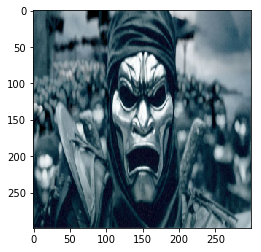

In [23]:
img = np.reshape(img, [299, 299, 3])
plt.imshow(img/255.)
plt.show()

We can see that the inputs are always scaled to 299x299. Deep Dream uses a pyramid of input gradient with a scaling factor. We need to pad zeros to get away with this problem.

In [78]:
ResizeBilinear.get_shape().as_list()

[1, 299, 299, 3]

### Lets define some helper functions

* Load a Jpeg image to a array
* plot/save image to the disk
* plot gradient

In [49]:
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

def plot_image(image, filename=None):
    
    # pixel-values should be between 0 and 255 and conver to bytes
    image = np.clip(image, 0.0, 255.0).astype(np.uint8)
    
    if filename is None:
        display(Image.fromarray(image))
    else:
        with open(filename, 'wb') as file:
            PIL.Image.fromarray(image).save(file, 'jpeg')

def plot_gradient(grad):
    # Normalize between 0 and 1
    grad_norm = (grad - grad.min())/(grad.max() - grad.min()) 
    
    plt.imshow(grad_norm, interpolation='bilinear')
    plt.show()

In [106]:
# Resize images for Deep dream

#input tensor size for image scaling
t_in_size = ResizeBilinear.get_shape().as_list()[1] 

def resize_image(image, scale, octave=1, inv=0):
    
    # resize to the new shape
    size = (np.array([t_in_size, t_in_size])/(scale*octave)).astype('int')
    
    #reverse the size for PIL (widh x height is reversed in PIL vs numpy)
    size = tuple(reversed(size))
    
    img = np.clip(image, 0.0, 255.0).astype(np.uint8)    
    img = Image.fromarray(img)
    
    if inv is 0:
        img_t_size = img.resize([t_in_size, t_in_size], PIL.Image.LANCZOS)
        img_resized = img.resize(size, PIL.Image.LANCZOS)
        out = ImageOps.expand(img_resized, border=(t_in_size-size[0])>>1, fill='black')
    else:
        img_without_border = ImageOps.crop(img, border=(t_in_size-size[0]>>1))
        out = img_without_border.resize([t_in_size, t_in_size], PIL.Image.LANCZOS)
    
    print('Output image size', out.size)
    return out

Output image size (299, 299)


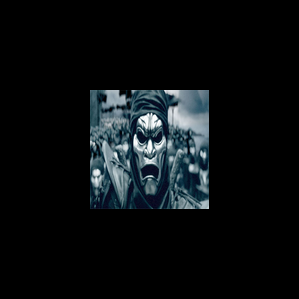

In [116]:
# Lets try scaling twice 
img = Image.open('360.jpg')
img = np.array(img)[:, :, 0:3]
r_img = resize_image(img, 1.25, 2)
plot_image(r_img)

Output image size (299, 299)


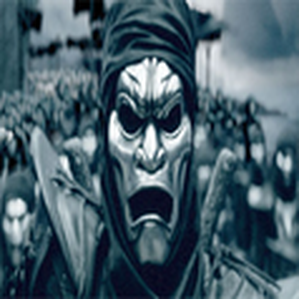

In [117]:
#Lets rescale it back
img_1 = resize_image(r_img, 1.25, 2, 1)
plot_image(img_1)

### Lets add the gradient of the image to a given tensor to amplify patterns in a input image

In [ ]:
layer = 'import/mixed_4/tower_2/conv/Conv2D:0'

#Get the tensor
tensor =  graph.get_tensor_by_name(layer)

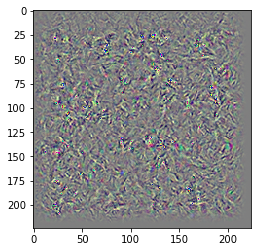

In [32]:
layer = 'import/mixed_4/tower_2/conv/Conv2D:0'
#layer = 'import/mixed_3/tower/conv_2/Conv2D:0'
#layer = 'import/mixed_1/tower_2/conv/Conv2D:0'
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

channel = 50
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0


def showarray(a, fmt='jpeg'):
    plt.imshow(a)
    plt.show()
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name(layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img_noise})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:,:,:,channel])

## Multiscale

In [33]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

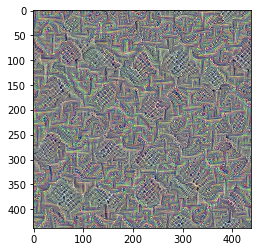

In [40]:

def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T(layer)[:,:,:,channel])

## Laplacian Pyramid Gradient Normalization

In [41]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

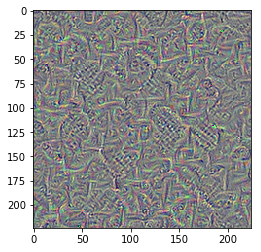

In [42]:
from functools import partial
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=4, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            #g = lap_norm_func(g)
            #img += g*step
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))
        return visstd(img)

img = render_lapnorm(T(layer)[:,:,:,channel])

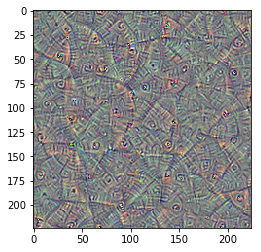

In [39]:
img = render_lapnorm(T(layer)[:,:,:,65])
img = np.uint8(np.clip(img, 0, 1)*255)
Image.fromarray(img).save('out.jpg')

### Deep Dream

In [29]:

def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(visstd(img))
        return visstd(img)

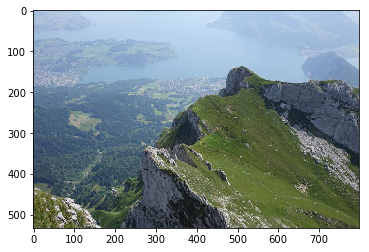

In [30]:
img0 = Image.open('mount.jpg')
img0 = np.float32(img0)
plt.imshow(img0/255.)
plt.show()

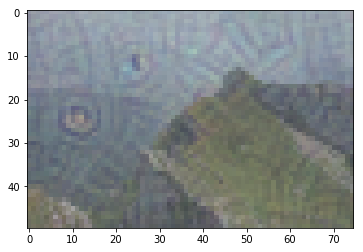

In [31]:
#render_deepdream(tf.square(T('import/mixed_9/tower_2/conv/Conv2D:0')), img0)
img = render_deepdream(tf.square(T(layer)[:,:,:,65]), img0, iter_n=20, step=1.5, octave_n=5, octave_scale=1.8)
img = np.uint8(np.clip(img, 0, 1)*255)
Image.fromarray(img).save('out.jpg')
